# 5. 프로젝트 : 인공지능과 가위바위보 하기
##### !. VScode 플랫폼을 사용하여 가상환경 Python 3.9.7버전에서 작성되었습니다.


---

### Step.0. 라이브러리 import 및 데이터 전처리

In [1]:
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os
print(tf.__version__)
print(np.__version__)

2.8.0
1.22.3


In [18]:
#이미지를 제공해주신 경문님, 창환님, 범석님, 오연님, 형진님, 해창님, 예슬님, 세한님 감사드립니다.


### Image reshape


In [2]:
#사진의 크기를 224x224에서 28x28로 변경
def resize_images(img_path):
	images = glob.glob(img_path+"/*.jpg")
	print(len(images), " images to be resized.")

	# 각 이미지 사이즈 변경
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

In [3]:
# 디렉토리에 특수문자가 들어가면 os 및 glob기능들이 제대로 쓰이지 않으니 조심할것.
#ex #image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/[E_05]Sequential/rock_scissor_paper/paper/1200.jpeg"
#print(image_dir_path) #경로 확인용
# 이미지 확인용 이미지 불러오기
mmm = Image.open(os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/paper/1200.jpg")
#mmm = Image.open("/Users/hpcd/Desktop/Code/LMS/E_05_Sequential/scissor/1.jpg")
# 이미지 불러오기.
mmm.show


<bound method Image.show of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7FDE80431EE0>>

In [4]:
image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")


1329  images to be resized.


/var/folders/bf/djd_zrlx0kg8fhjfrqdvzsg00000gq/T/ipykernel_17281/3293707581.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


1329  images resized.
가위 이미지 resize 완료!
1120  images to be resized.
1120  images resized.
바위 이미지 resize 완료!
1211  images to be resized.
1211  images resized.
보 이미지 resize 완료!


---

### (본문)

# 라벨링 및 데이터 스플릿

In [5]:
# import numpy as np
# 이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
def load_data(img_path, number_of_data=3660):  # 가위바위보 이미지 개수 총합에 주의.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28 # resize할 크기
    color=3 # 컬러는 3, 흑백은 1
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 3660 입니다.
x_train shape: (3660, 28, 28, 3)
y_train shape: (3660,)


라벨:  0


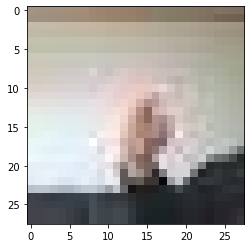

In [6]:
#import matplotlib.pyplot as plt
# 이미지 불러오기
plt.imshow(x_train[0])
print('라벨: ', y_train[0])


## 딥러닝 네트워크 설계

In [16]:
#import tensorflow as tf
#from tensorflow import keras
#import numpy as np
# tf.keras의 Sequential API를 이용하여 LeNet이라는 딥러닝 네트워크를 설계
# 정확도를 높이기 위해 변경할 수 있는 하이퍼파라미터들
# n_epoch값도 변경 가능하나 너무 높아지면 overfitting 문제가 발생 하므로 건드리지 않는게 좋음
n_channel_1=20
n_channel_2=40
n_dense=30

model=keras.models.Sequential()
# input_shape=(이미지 높이,이미지 너비,채널 수) # 채널 수 흑백이면 1, 컬러면 3으로 설정
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))  # 히든 레이어

model.add(keras.layers.Dense(3, activation='softmax'))  # 종속 변수 컬럼 3

print('Model에 추가된 Layer 개수: ', len(model.layers))

# 만든 딥러닝 네트워크 모델 확인
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 20)        560       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 20)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 40)        7240      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 40)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (

## 딥러닝 네트워크 학습

In [13]:
x_train_reshaped=x_train_norm.reshape(-1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됨.

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 학습(Fit)
n_train_epoch = 20
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch, validation_split=0.2, batch_size=10)  # epochs=n # n번 반복해서 학습시키기

Epoch 1/20
293/293 [==============================] - 5s 13ms/step - loss: 0.8587 - accuracy: 0.5963 - val_loss: 1.0138 - val_accuracy: 0.3784
Epoch 2/20
293/293 [==============================] - 4s 14ms/step - loss: 0.5136 - accuracy: 0.7927 - val_loss: 1.4918 - val_accuracy: 0.3238
Epoch 3/20
293/293 [==============================] - 5s 15ms/step - loss: 0.2960 - accuracy: 0.8856 - val_loss: 1.6071 - val_accuracy: 0.4126
Epoch 4/20
293/293 [==============================] - 6s 20ms/step - loss: 0.2222 - accuracy: 0.9150 - val_loss: 1.0704 - val_accuracy: 0.6598
Epoch 5/20
293/293 [==============================] - 7s 24ms/step - loss: 0.1619 - accuracy: 0.9457 - val_loss: 0.8362 - val_accuracy: 0.7131
Epoch 6/20
293/293 [==============================] - 9s 30ms/step - loss: 0.1332 - accuracy: 0.9553 - val_loss: 0.4369 - val_accuracy: 0.8470
Epoch 7/20
293/293 [==============================] - 10s 34ms/step - loss: 0.0983 - accuracy: 0.9676 - val_loss: 0.7940 - val_accuracy: 0.721

## 테스트

In [14]:
# x_test, y_test 생성
# test 데이터는 오버피팅을 피하기 위해 사진을 교체해서 진행
image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/test/scissor"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/test/rock"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/test/paper"
resize_images(image_dir_path)

image_dir_path = os.getenv("HOME") + "/Desktop/Code/LMS/E_05_Sequential/scissor_rock_paper/test" 
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

1329  images to be resized.


/var/folders/bf/djd_zrlx0kg8fhjfrqdvzsg00000gq/T/ipykernel_17281/3293707581.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


1329  images resized.
1120  images to be resized.
1120  images resized.
1211  images to be resized.
1211  images resized.
학습데이터(x_train)의 이미지 개수는 3660 입니다.
x_test shape: (3660, 28, 28, 3)
y_test shape: (3660,)


In [15]:
x_test_reshaped=x_test_norm.reshape(-1, 28, 28, 3)

test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))
# accuracy 85% 출력

115/115 - 2s - loss: 0.5051 - accuracy: 0.8598 - 2s/epoch - 15ms/step
test_loss: 0.5051233768463135 
test_accuracy: 0.8598360419273376


---

### 평가기준.

1. 이미지 분류기 모델이 성공적으로 만들어졌는가?  
트레이닝이 정상적으로 수행되었음  
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?  
데이터셋의 다양성, 정규화 등의 시도가 적절하였음  
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?  
60% 이상 도달하였음  

### 회고록.

실제로 찍은 가위, 바위, 보 이미지를 활용해 적절한 데이터 전처리를 거쳐 분류모델을 만들기 위한 딥러닝 네트워크 설계및 학습을 통해 만들어진 나만의 모델을 통해 다른 사진들과 비교해 적절한 test accuracy를 뽑아내기 위해 여러 하이퍼파라미터 값들을 바꿔 모델의 정확도를 높이는 다섯번째 explation이었다.  
지금까지 친절하게 a-z까지 잘 설명되어있던 앞선 exp와는 달리 설명 부분들이 조금씩 간소화된게 있어 초반 부분 이해하는데에 어려움을 겪었다.  
코드를 찾아보면서 처음 모델을 만들었을 때는 accuracy가 95% 이상이 나와 너무 놀랐었다.  
천천히 코드를 리뷰해보니 train data와 test data가 같았음을 깨달았고 이로 인해 오버피팅이 생겼음을 깨달았다.  
다섯번째 exp 과제를 받은날에 해창퍼실님이 넌지시 말씀해주셨던 그 상황이었다.  
다른 사진에서도 분류 모델이 제대로 작동하는지 확인하기 위해 테스트 사진을 바꾸자 accuracy가 굉장히 낮은 10%이하가 나왔다.  
이 상황을 타개하기 위해 아무리 하이퍼 파라미터 값을 바꿔도 accuracy 값은 올라가지 않았기에 굉장히 막막했었다.  
다행히도 같은 aiffel 식구분들이 많은 사진을 공유해주셨고 이 데이터를 활용해 대량의 사진을 집어넣었고 data가 많아지니 실제 모델 성능도 좋아져 accuracy가 굉장히 높아졌다.  
다양한 환경에서 찍은 사진들이기에 빛, 각도, 가위의 모양 등이 달라 정확도를 100%까지 끌어올릴 수는 없었지만 그럼에도 exp에서 제시한 %를 넘길 수 있어서 기뻤다.   
aiffel 식구분들께 이 자리를 빌어 감사의 인사를 올린다.  
이번 실습을 통해 하이퍼 파라미터도 중요하지만 데이터의 물량도 중요함을 다시한번 깨달았다.  
왜 딥러닝에서 데이터가 중요한지도 말이다.  

이번 exp를 진행하기 위해 여러 코드를 찾던 중 실시간으로 움직이는 손모양을 분석하여 실시간으로 가위 바위 보를 인식하는 코드나 사람의 얼굴 표정을 인식해 감정을 구분해보는 코드들도 있었다.  
CV로 나아가기 위해서는 이번 모델에 원리를 잘 이해하고 넘어가야 할 필요가 있음.


----

### Reference. (APA)

Tensorflow 101 (https://www.youtube.com/playlist?list=PLl1irxoYh2wyLwJutUZx5Q_QEEDZoXBnz)  
Tensorflow 102 - 이미지 분류(CNN) (https://www.youtube.com/playlist?list=PLl1irxoYh2wzOOU9hvJqMYc215wAlxrpp)


-----